In [3]:
import deorbit
import matplotlib.pyplot as plt
import deorbit.data_models
from deorbit.predictor import EKF
from deorbit.utils.dataio import load_sim_data, load_sim_config
from deorbit.utils.plotting import plot_trajectories, plot_height, plot_crash_site
import numpy as np
from deorbit.observer import Observer


In [4]:
save_path = "eg/EKF_example_noise_2s/"

sim_data = load_sim_data(save_path)
sim_config = load_sim_config(save_path)

if sim_data is None or sim_config is None:
    np.random.seed(0)
    sim = deorbit.simulator.run(
        "RK4",
        "coesa_atmos_fast",
        initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 7820)),
        noise_types = {"gaussian": {"noise_strength": 0.005}, "impulse": {"impulse_strength": 0.03, "impulse_probability": 1e-5}},
        time_step=2,
    )
    sim_data = sim.gather_data()
    sim_config = sim.export_config()
    sim.save_data(save_path)
else:
    print("Loaded data from file")

Loaded data from file


In [5]:
obs = Observer(number_of_radars=10, radar_variance_per_m=1)
sim_states = sim_data.state_array()
sim_times = sim_data.times

obs.run(sim_states=sim_states, sim_times=sim_times, checking_interval=100)

observation_times = obs.observed_times
observation_states = obs.observed_states
observed_covariances = obs.observed_covariances

observations = (observation_states, observation_times)

In [6]:
# Define process and measurement noise covariance matrices
Q = np.diag([0.1, 0.1, 0.01, 0.01])#process noise
P = np.eye(4) #error covariance matrix - represents uncertainty in state estimation

# Measurement matrix H (assuming all states are measured directly)
H = np.eye(4)

dt = sim_config.simulation_method_kwargs.time_step

ekf = EKF()

estimated_traj, uncertainties, estimated_times = ekf.run(observations, dt=dt, Q=Q, R=observed_covariances, P=P, H=H)

100%|██████████| 69/69 [00:04<00:00, 15.40it/s]


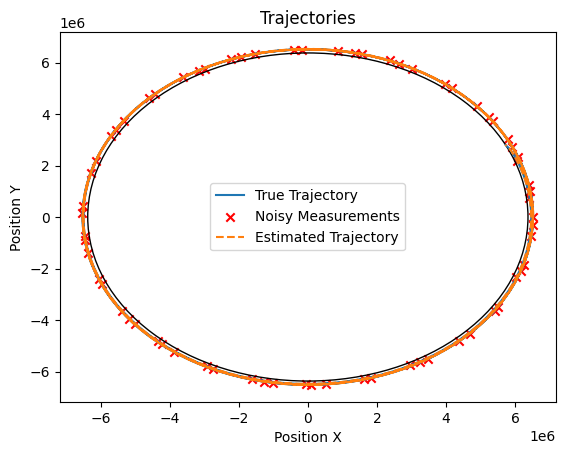

In [7]:
true_traj = sim_data.state_array()[:, :2]

crash_coords = true_traj[-1, :]




plot_trajectories(true_traj, observations=observation_states, estimated_traj=estimated_traj)

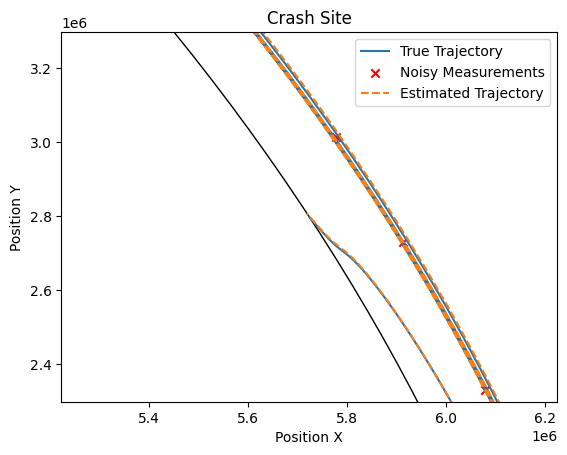

In [8]:
plot_crash_site(true_traj, observations=observation_states, estimated_traj=estimated_traj)

10300
6037021.528736004
-2336558.8157971823


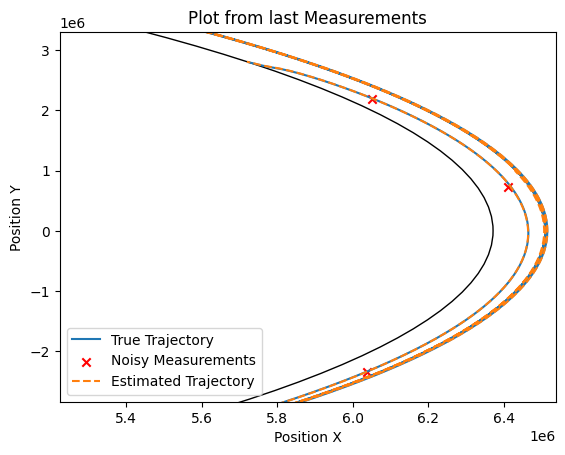

In [2]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

plot_duration = 1000

start_index = np.argmax(sim_times > observation_times[0])
start_time = sim_times[start_index]
end_time = start_time + plot_duration

true_traj_slice = slice(start_index, int(end_time/dt))
est_traj_slice = slice(0, int(plot_duration/dt))
measure_slice = slice(0, np.argmax(observation_times > end_time))

ax1.plot(true_traj[:, 0][true_traj_slice], true_traj[:, 1][true_traj_slice], label='True Trajectory')
ax1.scatter(observation_states[:, 0][measure_slice], observation_states[:, 1][measure_slice], marker='x', color='r', label='Noisy Measurements')
ax1.plot(estimated_traj[:, 0][est_traj_slice], estimated_traj[:, 1][est_traj_slice], label='EKF Estimated Trajectory', linestyle='--')
ax1.set_title('Extended Kalman Filter for Satellite Motion')
ax1.set_xlabel('Position X')
ax1.set_ylabel('Position Y')


ax2.plot(true_traj[:, 0], true_traj[:, 1], label='True Trajectory')
ax2.scatter(observation_states[:, 0], observation_states[:, 1], marker='x', color='r', label='Noisy Measurements')
ax2.plot(estimated_traj[:, 0], estimated_traj[:, 1], label='EKF Estimated Trajectory', linestyle='--')
ax2.set_title('Extended Kalman Filter for Satellite Motion')
ax2.set_xlabel('Position X')
ax2.set_ylabel('Position Y')
ax2.set_xlim([crash_coords[0]-3e5, crash_coords[0]+3e5])
ax2.set_ylim([crash_coords[1]-3e5, crash_coords[1]+3e5])
earth = plt.Circle((0, 0), radius=deorbit.constants.EARTH_RADIUS, fill=False)
ax2.add_patch(earth)
ax1.legend()

plt.show()

NameError: name 'plt' is not defined